In [27]:
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

tmp_dataset = pd.read_csv('dataset/gender_info.csv')
training_folder = 'dataset/Training'
testing_folder = 'dataset/Testing'

training_files = os.listdir(training_folder)
testing_files = os.listdir(testing_folder)


def process_csv(files, folder):
    tmp_list_male = []
    tmp_list_female = []

    for fname in files:
        name, extension = os.path.splitext(fname)
        row = tmp_dataset.loc[tmp_dataset['File Names'] == name]

        if not row.empty:
            new_row = {
                'path': f'{folder}/{fname}',
                'gender': row['Gender'].values[0],
                'filename': name
            }
            if row['Gender'].values[0] == 'Male':
                tmp_list_male.append(new_row)
            else:
                tmp_list_female.append(new_row)
        else:
            print('empty dataset detected', name, row)

    female_dataset = pd.DataFrame(tmp_list_female)
    male_dataset = pd.DataFrame(tmp_list_male)

    return male_dataset, female_dataset


train_male_dataset, train_female_dataset = process_csv(training_files, training_folder)

test_male_dataset, test_female_dataset = process_csv(testing_files, testing_folder)



assert (len(train_male_dataset) + len(train_female_dataset)) == len(training_files)
assert (len(test_male_dataset) + len(test_female_dataset)) == len(testing_files)


In [29]:
import librosa
import pickle
import python_speech_features as mfcc
from sklearn.mixture import GaussianMixture as GMM
import os
import numpy as np
from sklearn import preprocessing


def get_MFCC(sr, audio):
    features = mfcc.mfcc(audio, sr, 0.025, 0.01, 13, appendEnergy=False)
    features = preprocessing.scale(features)
    return features


def get_features(train_dataset, test_dataset):
    # Train features
    features_train = []
    for row in train_dataset.iterrows():
        # (0, ('path', 'dataset/Training/2078-142845-0000.flac') ('gender', 'Male') ('filename', '2078-142845-0000'))
        file_path = row[1][0]
        audio, sample_rate = librosa.load(file_path, res_type='soxr_vhq')

        vector = get_MFCC(sample_rate, audio)
        if len(features_train) == 0:
            features_train = vector
        else:
            features_train = np.vstack((features_train, vector))

    # Test features  
    features_test = []
    for row in test_dataset.iterrows():
        file_path = row[1][0]
        audio, sample_rate = librosa.load(file_path, res_type='soxr_vhq')
        vector = get_MFCC(sample_rate, audio)
        if len(features_test) == 0:
            features_test = vector
        else:
            features_test = np.vstack((features_test, vector))

    return features_train, features_test


features_train_male, features_test_male = get_features(train_male_dataset, test_male_dataset)
features_train_female, features_test_female = get_features(train_female_dataset, test_female_dataset)


gmm_male = GMM(n_components = 8, max_iter = 200, covariance_type = 'diag', n_init = 3)
gmm_male.fit(features_train_male)

gmm_female = GMM(n_components = 8, max_iter=200, covariance_type='diag', n_init = 3)
gmm_female.fit(features_train_female)


pickle.dump(gmm_male, open("voice_model/male.gmm", "wb" ))
pickle.dump(gmm_female, open("voice_model/female.gmm", "wb" ))


Confusion Matrix:
[[111   5]
 [  2 105]]
F-score: 0.9686
Balanced Accuracy: 0.9691


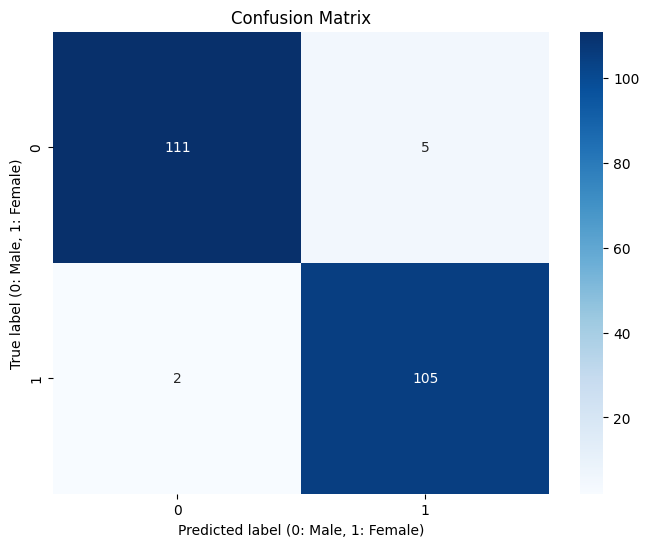

In [25]:
from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns



def run_gender_analysis(audio_path):
    audio, sample_rate = librosa.load(audio_path, res_type='soxr_vhq')
    features = get_MFCC(sample_rate, audio)

    log_likelihood_male = np.array(gmm_male.score(features)).sum()
    log_likelihood_female = np.array(gmm_female.score(features)).sum()

    if log_likelihood_male >= log_likelihood_female:
        return "Male"
    else:
        return "Female"

full_test_dataset = pd.concat([test_male_dataset, test_female_dataset])

# 0 for male
# 1 for female

true_label = []
pred_label = []


for row in full_test_dataset.iterrows():
    file_path = row[1]['path']
    gender = row[1]['gender']

    if gender == 'Male':
        true_label.append(0)
    else:
        true_label.append(1)
        
    result = run_gender_analysis(file_path)
    
    if result == gender :
        if gender == 'Male':
            pred_label.append(0)
        else:
            pred_label.append(1)
    else:
        if gender == 'Male':
            pred_label.append(1)
        else:
            pred_label.append(0)

cm = confusion_matrix(true_label, pred_label)

# Calculate F-score
f_score = f1_score(true_label, pred_label, average='weighted')

# Calculate balanced accuracy
balanced_acc = balanced_accuracy_score(true_label, pred_label)

print(f"Confusion Matrix:\n{cm}")
print(f"F-score: {f_score:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label (0: Male, 1: Female)')
plt.xlabel('Predicted label (0: Male, 1: Female)')
plt.show()

